In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import flow.visualize.visualize_ring as visualize_ring

import torch
print(torch.__version__)

# Anti-Flow specific functions for  detection:
from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

print('Libraries loaded.')

1.7.1
Libraries loaded.


In [11]:
import utils
reload(utils)
from utils import run_ring_sim_variable_cfm

In [10]:
import Adversaries.controllers
reload(Adversaries.controllers)
from Adversaries.controllers.base_controller import BaseController


class Bando_OVM_FTL(BaseController):
    def __init__(self,
                 veh_id,
                 car_following_params,
                 delay=0.0,
                 noise=0.0,
                 fail_safe=None,
                 a=0.8,
                 b=20.0,
                 s0=1.0,
                 s1=2.0,
                 Vm=15.0):
        #Inherit the base controller:
        BaseController.__init__(
            self,
            veh_id,
            car_following_params,
            delay=delay,
            fail_safe=fail_safe,
            noise=noise)
        
        # Model parameters, which can be changed at initialization:
        self.Vm = Vm
        self.s0 = s0
        self.s1 = s1
        self.a = a
        self.b = b
        
    def get_accel(self, env):
        """This function is queried during simulation
           to acquire an acceleration value:"""
        # env contains all information on the simulation, and 
        # can be queried to get the state of different vehicles.
        # We assume this vehicle has access only to its own state,
        # and the position/speed of the vehicle ahead of it. 
        lead_id = env.k.vehicle.get_leader(self.veh_id) #Who is the leader
        v_l = env.k.vehicle.get_speed(lead_id) #Leader speed
        v = env.k.vehicle.get_speed(self.veh_id) #vehicle's own speed
        s = env.k.vehicle.get_headway(self.veh_id) #inter-vehicle spacing to leader

        # We build this model off the popular Bando OV-FTL model:
        v_opt = self.OV(s)
        ftl = self.FTL(v,v_l,s)
        u = self.a*(v_opt-v) + self.b*ftl
        
        return u #return the acceleration that is set above.
        
    def get_custom_accel(self, v, v_l, s):
        """This function can be queried at any time,
           and is useful for analyzing controller
           behavior outside of a sim."""
        v_opt = self.OV(s)
        ftl = self.FTL(v,v_l,s)
        u = self.a*(v_opt-v) + self.b*ftl
        return u
    
    def OV(self,s):
        return self.Vm*((np.tanh(s/self.s0-self.s1)+np.tanh(self.s1))/(1+np.tanh(self.s1)))
    
    def FTL(self,v,v_l,s):
        return (v_l-v)/(s**2)
    
print('Bando OVM-FTL model initialized.')

Non adversarial CFM initiialized.


In [13]:
#Run with just one class of driver:
driver_controller_list = []
num_drivers = 20

a=0.8
b=20.0
s0=1.0
s1=2.0
Vm=15.0

label = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list = [label,cfm_controller,num_drivers]
print('Simulation params initialized.')

Simulation params initialized.


In [14]:
reload(utils)
sim_res_list = utils.run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list)

Running ring simulation, ring length: 300
Round 0, return: 4143.314066525799
data/ring_no_attack_20211231-1218501640971130.5532851-0_emission.csv data
Average, std returns: 4143.314066525799, 0.0
Average, std velocities: 8.360725577755138, 0.0
Average, std outflows: 0.0, 0.0
Total time: 26.59123921394348
steps/second: 214.6711849204435


[{'returns': [4143.314066525799],
  'velocities': [8.360725577755138],
  'outflows': [0.0]},
 'data/ring_no_attack_20211231-1218501640971130.5532851-0_emission.csv']

Data loaded.


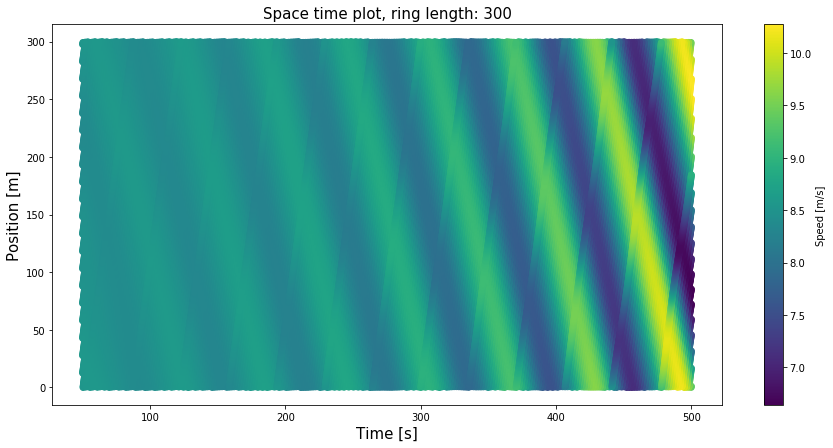

In [17]:
import os
emission_path = os.path.join(os.getcwd(),sim_res_list[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_path)

In [18]:
#Run with just one class of driver:
driver_controller_list = []
num_drivers = 10

a=0.8
b=20.0
s0=1.0
s1=2.0
Vm=15.0

label = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label,cfm_controller,num_drivers])

a=0.2
b=10.0
s0=1.0
s1=3.0
Vm=13.0

label = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label,cfm_controller,num_drivers])


print('Simulation params initialized: ')
print(driver_controller_list)

Simulation params initialized: 
[['bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0', (<class '__main__.Bando_OVM_FTL'>, {'a': 0.8, 'b': 20.0, 's0': 1.0, 's1': 2.0, 'Vm': 15.0, 'noise': 0.1}), 10], ['bando_ftl_ovm_a0.2_b10.0_s01.0_s13.0_Vm13.0', (<class '__main__.Bando_OVM_FTL'>, {'a': 0.2, 'b': 10.0, 's0': 1.0, 's1': 3.0, 'Vm': 13.0, 'noise': 0.1}), 10]]


In [39]:
import utils
reload(utils)
sim_res_list = utils.run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list,sim_time=1000)

Number unique drivers: 2
Running ring simulation, ring length: 300
Round 0, return: 7722.801436451524
data/ring_variable_cfm_20220101-1312081641060728.222943-0_emission.csv data
Average, std returns: 7722.801436451524, 0.0
Average, std velocities: 8.328280436699183, 0.0
Average, std outflows: 0.0, 0.0
Total time: 67.00847721099854
steps/second: 172.95178672691955


Data loaded.


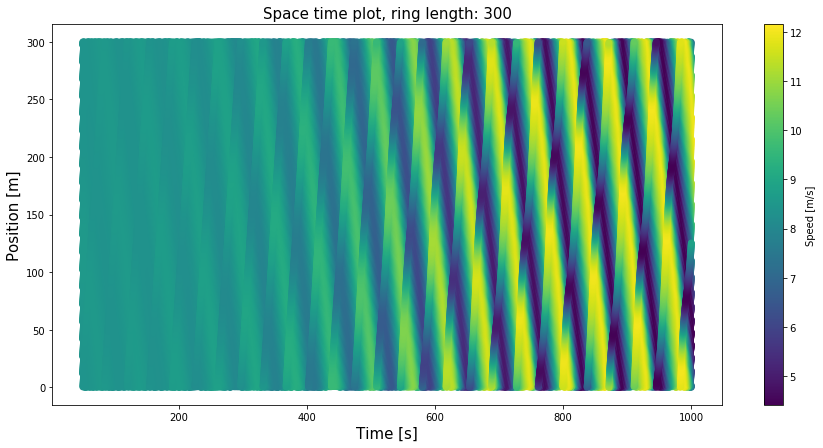

In [40]:
emission_path = os.path.join(os.getcwd(),sim_res_list[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_path)

In [41]:
timeseries_dict = visualize_ring.get_sim_timeseries(csv_path = emission_path)

Data loaded.


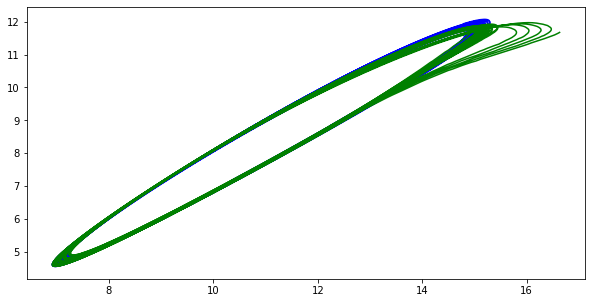

In [47]:
import matplotlib.pyplot as plt

begin_time = 700.0
end_time = 800.0

label_1 = 'bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0'
label_2 = 'bando_ftl_ovm_a0.2_b10.0_s01.0_s13.0_Vm13.0'


veh_ids = (timeseries_dict.keys())
plt.figure(figsize=[10,5])
for veh_id in veh_ids:
    time = timeseries_dict[veh_id][:,0]
    index_select = np.logical_and(time>begin_time,time<end_time)
    
    
    speed = timeseries_dict[veh_id][:,1]
    spacing = timeseries_dict[veh_id][:,2]
    
    speed = speed[index_select]
    spacing = spacing[index_select]
    
    if(label_1 in veh_id):
        plt.plot(spacing,speed,'b')
    elif(label_2 in veh_id):
        plt.plot(spacing,speed,'g')
